# Stepwise Head Score Analyzer

分析 `08b83a6feb34df1a6011b80c3c00c7563e963b07_stepwise.json` 的逐步头部分数，默认在每个 step 使用独立的瞬时得分进行对比，并可视化层-头热力图与演化。


In [14]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator

sns.set_theme(style="whitegrid")

In [15]:
STEPWISE_PATH = Path("head_score/08b83a6feb34df1a6011b80c3c00c7563e963b07_stepwise.json")
if not STEPWISE_PATH.exists():
    raise FileNotFoundError(f"找不到数据文件: {STEPWISE_PATH}")

raw_data = json.loads(STEPWISE_PATH.read_text())
if not isinstance(raw_data, dict):
    raise TypeError(f"期望 JSON 是字典格式，得到 {type(raw_data).__name__}")

print(f"Loaded {len(raw_data)} steps from {STEPWISE_PATH}")

Loaded 32 steps from head_score/08b83a6feb34df1a6011b80c3c00c7563e963b07_stepwise.json


In [16]:
AGGREGATION = "mean"  # 可选: "mean", "sum", "median"
AGG_FUNCS = {
    "mean": np.mean,
    "sum": np.sum,
    "median": np.median,
}

try:
    agg_fn = AGG_FUNCS[AGGREGATION]
except KeyError as exc:
    raise ValueError(f"不支持的聚合方式: {AGGREGATION}") from exc


def parse_step_key(key):
    if isinstance(key, str) and key.startswith("step_"):
        suffix = key.split("_", 1)[1]
        if suffix.isdigit():
            return int(suffix)
    return key


sorted_steps = sorted(raw_data.items(), key=lambda item: parse_step_key(item[0]))

stepwise = []
for step_key, head_scores in sorted_steps:
    parsed_scores = []
    for head, values in head_scores.items():
        if not values:
            continue
        values_arr = np.asarray(values, dtype=np.float32)
        parsed_scores.append({
            "head": head,
            "score": float(agg_fn(values_arr)),
            "values": values_arr.tolist(),
            "count": int(values_arr.size),
            "std": float(values_arr.std(ddof=1)) if values_arr.size > 1 else 0.0,
        })
    stepwise.append({
        "step": parse_step_key(step_key),
        "step_key": step_key,
        "head_scores": parsed_scores,
    })

num_steps = len(stepwise)
if num_steps == 0:
    raise ValueError("stepwise 数据为空，无法继续分析")

print(f"Prepared {num_steps} steps using '{AGGREGATION}' aggregation")

Prepared 32 steps using 'mean' aggregation


In [17]:
head_pairs = {
    tuple(map(int, hs["head"].split("-")))
    for step in stepwise
    for hs in step["head_scores"]
}
if not head_pairs:
    raise ValueError("未找到任何 head 数据")

max_layer = max(layer for layer, _ in head_pairs)
max_head = max(head for _, head in head_pairs)
num_layers = max_layer + 1
num_heads = max_head + 1
print(f"Detected {num_layers} layers, {num_heads} heads per layer")

scores = np.zeros((num_steps, num_layers, num_heads), dtype=np.float32)
for step_idx, step in enumerate(stepwise):
    for hs in step["head_scores"]:
        layer, head = map(int, hs["head"].split("-"))
        scores[step_idx, layer, head] = hs["score"]


Detected 32 layers, 32 heads per layer


In [18]:
rows = []
for step_idx, step in enumerate(stepwise):
    for hs in step["head_scores"]:
        layer, head = map(int, hs["head"].split("-"))
        rows.append({
            "step": step["step"],
            "step_key": step["step_key"],
            "layer": layer,
            "head": head,
            "score": hs["score"],
            "count": hs["count"],
            "std": hs["std"],
        })

if rows:
    df = pd.DataFrame(rows)
else:
    df = pd.DataFrame(columns=["step", "step_key", "layer", "head", "score", "count", "std"])

df.head()


,step,step_key,layer,head,score,count,std
0,1,step_1,0,0,0.240299,60,0.148491
1,1,step_1,0,1,0.285498,60,0.169767
2,1,step_1,0,2,0.219238,60,0.140212
3,1,step_1,0,3,0.104541,60,0.055738
4,1,step_1,0,4,0.187419,60,0.105106


In [19]:
# 绘制工具函数
TICK_STEP = 5

def _build_ticks(size, step):
    if size <= 0:
        return np.array([], dtype=int)
    ticks = np.arange(0, size, step, dtype=int)
    if ticks.size == 0:
        return np.array([size - 1], dtype=int)
    if (size - 1) - ticks[-1] >= step:
        ticks = np.append(ticks, size - 1)
    return ticks

def configure_heatmap_ticks(ax, num_rows, num_cols, step=TICK_STEP):
    # 控制热力图坐标刻度间隔
    yticks = _build_ticks(num_rows, step)
    xticks = _build_ticks(num_cols, step)
    if xticks.size:
        ax.set_xticks(xticks + 0.5)
        ax.set_xticklabels(xticks)
    if yticks.size:
        ax.set_yticks(yticks + 0.5)
        ax.set_yticklabels(yticks)

def plot_heatmap(matrix, title, vmin=None, vmax=None, cmap="viridis"):
    """绘制单张层-头热力图"""
    data = matrix.T  # 头作为Y轴，层作为X轴
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax)
    configure_heatmap_ticks(ax, data.shape[0], data.shape[1])
    ax.set_xlabel("Layer")
    ax.set_ylabel("Head")
    ax.set_title(title)
    plt.show()

step_vmin = float(scores.min())
step_vmax = float(scores.max())
print(f"Raw score range across steps: {step_vmin:.4f} – {step_vmax:.4f}")


Raw score range across steps: 0.0007 – 0.5343


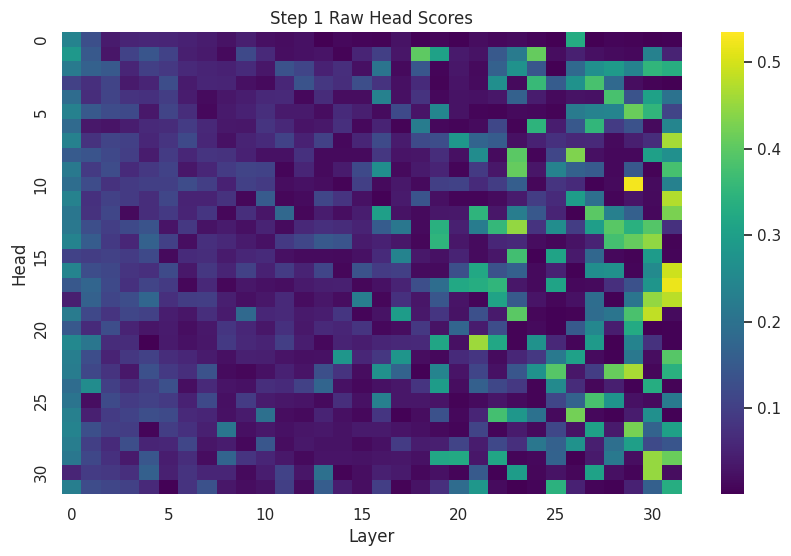

In [20]:
# 示例: 第一个 step 的瞬时得分热力图
plot_heatmap(scores[0], f"Step {stepwise[0]['step']} Raw Head Scores", vmin=step_vmin, vmax=step_vmax)

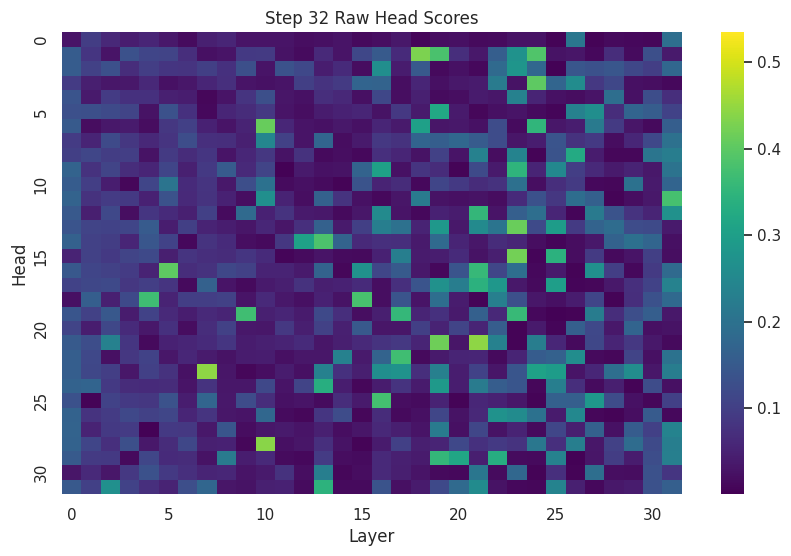

In [21]:
# 示例: 最后一个 step 的瞬时得分热力图
plot_heatmap(
    scores[-1],
    f"Step {stepwise[-1]['step']} Raw Head Scores",
    vmin=step_vmin,
    vmax=step_vmax,
)


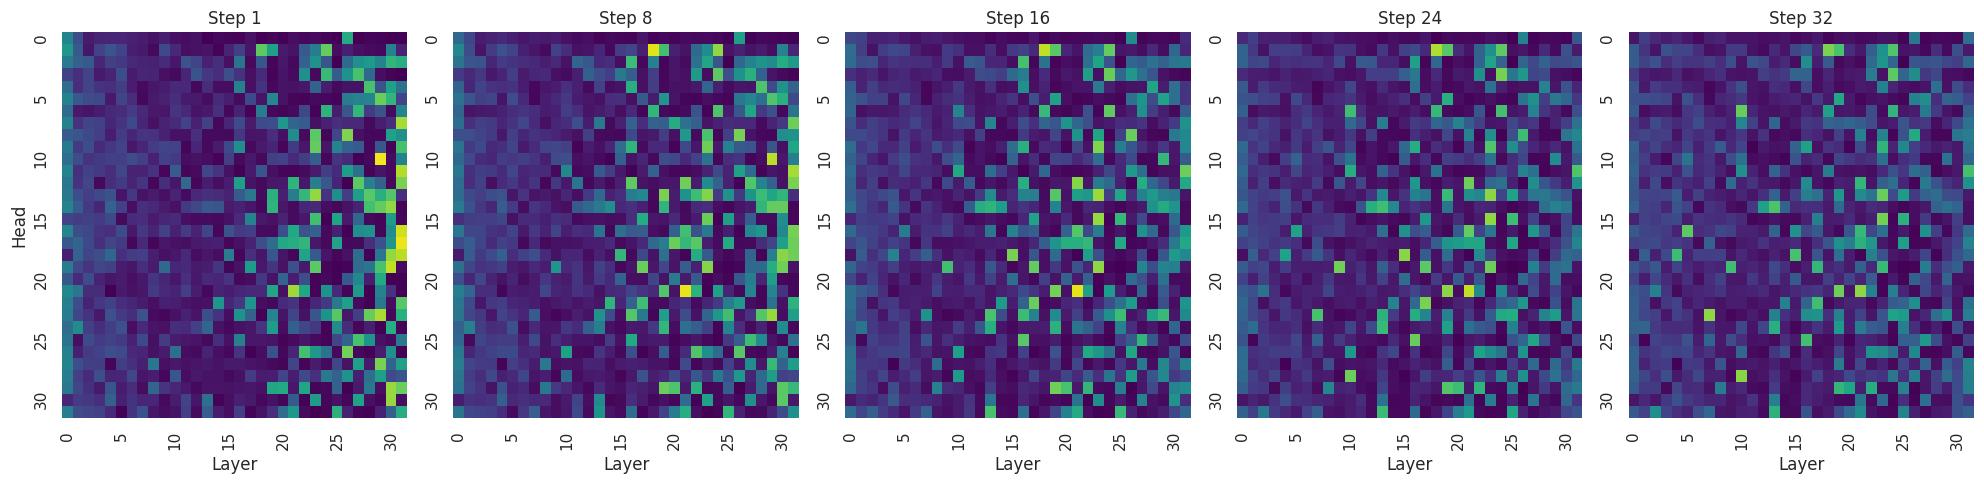

In [22]:
# 选取多个时间点，查看瞬时热力图的演化
milestones = np.linspace(0, num_steps - 1, num=5, dtype=int)
fig, axes = plt.subplots(1, len(milestones), figsize=(4 * len(milestones), 5), squeeze=False)
for ax, step_idx in zip(axes[0], milestones):
    data = scores[step_idx].T
    sns.heatmap(data, ax=ax, cmap="viridis", vmin=step_vmin, vmax=step_vmax, cbar=False)
    configure_heatmap_ticks(ax, data.shape[0], data.shape[1])
    ax.set_title(f"Step {stepwise[step_idx]['step']}")
    ax.set_xlabel("Layer")
    if ax is axes[0, 0]:
        ax.set_ylabel("Head")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()


In [23]:
# 动画展示瞬时热力图演化
fig, ax = plt.subplots(figsize=(8, 5))
data0 = scores[0].T
im = ax.imshow(data0, cmap="viridis", vmin=step_vmin, vmax=step_vmax, origin="upper")
configure_heatmap_ticks(ax, data0.shape[0], data0.shape[1])
ax.set_xlabel("Layer")
ax.set_ylabel("Head")
ax.set_title(f"Step {stepwise[0]['step']} Raw")
plt.close(fig)

def update(frame):
    data = scores[frame].T
    im.set_data(data)
    ax.set_title(f"Step {stepwise[frame]['step']} Raw")
    return (im,)

anim = FuncAnimation(fig, update, frames=num_steps, interval=500, blit=True)
HTML(anim.to_jshtml())


In [ ]:
# 相对得分热力图 (基于指定 step 的瞬时归一化)
last_step_scores = scores[-1]
total_last = float(last_step_scores.sum())
if total_last <= 0:
    relative_last = np.zeros_like(last_step_scores)
else:
    relative_last = last_step_scores / total_last

plot_heatmap(
    relative_last,
    f"Step {stepwise[-1]['step']} Relative Raw Share",
    vmin=0.0,
    vmax=float(relative_last.max() if relative_last.max() > 0 else 1.0),
    cmap="magma",
)


In [ ]:
# Top 30 头随步数瞬时得分演化
flat_totals = scores.sum(axis=0).reshape(-1)
top_k = min(30, flat_totals.size)
top_indices = np.argsort(flat_totals)[-top_k:][::-1]
head_labels = [
    f"{layer}-{head}"
    for layer, head in (divmod(idx, num_heads) for idx in top_indices)
]

top_traces = scores.reshape(num_steps, -1)[:, top_indices]
df_top = pd.DataFrame(top_traces, columns=head_labels)
df_top['step'] = [s['step'] for s in stepwise]
df_top_melt = df_top.melt(id_vars='step', var_name='head', value_name='raw_score')

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_top_melt, x='step', y='raw_score', hue='head', linewidth=1.5)
ax.xaxis.set_major_locator(MultipleLocator(TICK_STEP))
plt.title('Top 30 Heads Raw Score Evolution')
plt.xlabel('Step')
plt.ylabel('Raw Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Head', ncol=1)
plt.tight_layout()
plt.show()
